# Natural Computing - Assignment 2 - Swarm Intelligence
## Exercise 3 - PSO
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

This file contains our solution to exercise 3 of the "Swarm Intelligence" assignment of the Natural Computing course.

**NOTE:** ("!!!" denotes remarks/TODOs)

### Imports

In [2]:
from sklearn.cluster import KMeans # !!! Temporary (?), see K-means clustering algorithm below
from sklearn import datasets
import numpy as np
import random
import pdb
import matplotlib.pyplot as plt 
import itertools
from mpl_toolkits.mplot3d import Axes3D 

### PSO clustering algorithm

In [3]:
def PSO_clustering(n_clusters, n_particles, n_iterations, data, omega=0.7298, alpha_1=1.49618, alpha_2=1.49618, verbose=False):
    # Compute number of dimensions
    n_dims = data.shape[1]
    
    # Compute range of input data in every dimension (to ensure reasonable initial particles)
    ranges = [(min(data[:,dim]), max(data[:,dim])) for dim in range(n_dims)]
    
    # Initialize particles with random centroids
    particles, speeds = [], []
    for n in range(n_particles):
        # Generate a random particle by creating the desired number of random centroids
        particle = np.array([[random.uniform(r[0],r[1]) for r in ranges] for c in range(n_clusters)])
        # Add the particle to the list of particles
        particles.append(particle)
        # Add a speed of 0 to the list of speeds !!! 0 or random?
        speeds.append(np.zeros(particle.shape)) # speeds.append(np.random.uniform(-1,1,particle.shape))
    
    # Initialize local & global bests
    local_bests = [([],float('inf')) for particle in particles]
    global_best = ([],float('inf'))
    
    # Perform iterations until termination
    for iteration in range(n_iterations):
        if verbose:
            print(f"iteration {iteration}")
        
        # For each particle:
        for i,particle in enumerate(particles):
            # Compute fitness (quantization error)
            fitness = quantization_error(particle, data)
            # Update local best
            if fitness < local_bests[i][1]:
                local_bests[i] = (particle, fitness)
        
        # Update global best
        best_in_iteration = np.argmin([local_best[1] for local_best in local_bests])
        if local_bests[best_in_iteration][1] < global_best[1]:
            global_best = local_bests[best_in_iteration]
        
        # Update particles
        for i in range(n_particles):
            r_1 = np.random.uniform(0,1,particle.shape)
            r_2 = np.random.uniform(0,1,particle.shape)
            speeds[i] = omega*speeds[i] \
                      + np.multiply(alpha_1*r_1, local_bests[i][0]-particles[i]) \
                      + np.multiply(alpha_2*r_2, global_best[0]-particles[i])
            particles[i] = particles[i] + speeds[i]
    
    # Return the global best
    return global_best[0] 

## Obtain Clusters based on centroids and data 

In [4]:
def obtain_clusters(centroids, data):
    # Retrieve number of clusters
    n_clusters = len(centroids)

    # store the actual data_vectors in each cluster
    clusters_data_vectors =[ [] for i in range(n_clusters) ] 
    clusters_data_vectors_indices = [ [] for i in range(n_clusters) ]
    for index,datapoint in enumerate(data):
        # Compute Euclidean distance between this datapoint and all centroids
        distances = [np.sqrt(np.sum((centroid-datapoint)**2)) for centroid in centroids]

        # store data vector as well as data vector index in appropriate arrays
        clusters_data_vectors[np.argmin(distances)].append(datapoint)
        clusters_data_vectors_indices[np.argmin(distances)].append(index)
    clusters_data_vectors =[ np.array(l) for l in clusters_data_vectors ] 
    clusters_data_vectors_indices = [ np.array(l) for l in clusters_data_vectors_indices ] 
    return clusters_data_vectors, clusters_data_vectors_indices


### Quantization error

In [5]:
def quantization_error(particle, X):
    # Retrieve number of clusters
    n_clusters = len(particle)
    
    # Assign datapoints to clusters; store computed distances to corresponding centroids
    clusters = {i:[] for i in range(n_clusters)}

    for index,datapoint in enumerate(X):
        # Compute Euclidean distance between this datapoint and all centroids
        distances = [np.sqrt(np.sum((centroid-datapoint)**2)) for centroid in particle]
        # Assign datapoint to centroid with smallest distance, by storing distance in the corresponding array
        clusters[np.argmin(distances)].append(min(distances))

    # Compute quantization error as described in paper
    error = 0
    for c in clusters:
        error += sum(clusters[c])/len(clusters[c]) if clusters[c] else 0
    error = error/n_clusters
    
    # Return the computed error
    return error

### K-means clustering algorithm

In [6]:
# custom implementation
"""

SHOULD THE CLUSTERS BE RANDOMLY INITIALIZED IN THE BEGINNING?

"""
def KMeans_clustering(n_clusters, max_iter, data):
    
    input_dimension = data.shape[1]
    number_of_data_vectors = data.shape[0]
    ranges = [(min(data[:,dim]), max(data[:,dim])) for dim in range(input_dimension)]
    
    ## FROM SKLEARN SOURCE CODE...
    seeds = np.random.RandomState()
    seeds = seeds.permutation(data.shape[0])[:n_clusters]
    cluster_centroids = data[seeds]

    clusters = [ [] for x in range(n_clusters)]
    cluster_indices =  [ [] for x in range(n_clusters)] ## the indices of the data vectors..
    ## repeat for n_init iterations
    for iteration in range(max_iter):
        
        # calculate distance for each data vector
        # determine closest centroid vector

        for index, data_vector in enumerate(data):

            closest_centroid = np.argmin(np.sqrt(np.sum( (data_vector-cluster_centroids) ** 2 , axis=1)))
            if len(clusters[closest_centroid]) == 0:
                clusters[closest_centroid] = data_vector
            else:
                clusters[closest_centroid] = np.vstack( (clusters[closest_centroid], data_vector) )
            cluster_indices[closest_centroid].append(index)


        # recalculate cluster centroid vectors
        for index, centroid in enumerate(cluster_centroids):
            if (len(clusters[index]) == 0): # clusters could be empty..
                centroid = centroid
            else:
                centroid = (1 / len(clusters[index])) * np.sum(clusters[index])
        
    return cluster_centroids, clusters, cluster_indices

### Loading datasets

#### Artificial dataset I 
(as described [here](https://scholar.google.nl/scholar?hl=nl&as_sdt=0%2C5&q=Van+der+Merwe%2C+D.+W.%2C+and+Andries+Petrus+Engelbrecht.+%22Data+clustering+using+particle+swarm+optimization%22&btnG=))

In [7]:
artificial_dataset_size = 400

artificial_X = np.array([(random.uniform(-1,1), random.uniform(-1,1)) for i in range(artificial_dataset_size)])
artificial_Y = np.array([int((z_1 >= 0.7) or ((z_1 <= 0.3) and (z_2 >= -0.2 - z_1))) for (z_1,z_2) in artificial_X])
artificial_n_clusters = len(np.unique(artificial_Y))

#### Iris dataset

In [8]:
iris = datasets.load_iris()

iris_X = iris.data
iris_Y = iris.target
iris_n_clusters = len(np.unique(iris_Y))

### Testing

!!! Don't know if this is sufficient

#### Artificial dataset I

In [8]:
artificial_solution_PSO = PSO_clustering(artificial_n_clusters, 5, 100, artificial_X)
artificial_solution_KMeans,clusters,_ = KMeans_clustering(artificial_n_clusters, 100, artificial_X)

In [9]:
artificial_error_PSO = quantization_error(artificial_solution_PSO, artificial_X)
artificial_error_KMeans= quantization_error(artificial_solution_KMeans, artificial_X)
print(f"PSO quantization error on artificial dataset I: {artificial_error_PSO}")
print(f"KMeans quantization error on artificial dataset I: {artificial_error_KMeans}")

PSO quantization error on artificial dataset I: 0.3624920176779404
KMeans quantization error on artificial dataset I: 0.8607794843904554


In [10]:
## 30 iterations 

pso_quantization_errors = []
kmeans_quantization_errors = []



for trial in range(30):
    artificial_solution_PSO = PSO_clustering(artificial_n_clusters, 5, 100, artificial_X)
    artificial_solution_KMeans,kmeans_clusters,_ = KMeans_clustering(artificial_n_clusters, 100, artificial_X)
    artificial_error_PSO = quantization_error(artificial_solution_PSO, artificial_X)
    artificial_error_KMeans = quantization_error(artificial_solution_KMeans, artificial_X)

    pso_quantization_errors.append(artificial_error_PSO)
    kmeans_quantization_errors.append(artificial_error_KMeans)


    

In [11]:
print(f"Average kmeans quantization error over 30 simulations {np.average(kmeans_quantization_errors)} ± {np.std(kmeans_quantization_errors)}")
print(f"Average PSO quantization error over 30 simulations {np.average(pso_quantization_errors)} ± {np.std(pso_quantization_errors)}")



Average kmeans quantization error over 30 simulations 0.7071764769864703 ± 0.11977488527026595
Average PSO quantization error over 30 simulations 0.4811136893431915 ± 0.09031609729653813


#### Iris dataset

In [9]:
iris_solution_PSO = PSO_clustering(iris_n_clusters, 5, 100, iris_X)
iris_solution_KMeans,clusters,cluster_indices = KMeans_clustering(iris_n_clusters, 100, iris_X)

In [13]:
iris_error_PSO = quantization_error(iris_solution_PSO, iris_X)
iris_error_KMeans = quantization_error(iris_solution_KMeans, iris_X)
print(f"PSO quantization error on iris dataset: {iris_error_PSO}")
print(f"KMeans quantization error on iris dataset: {iris_error_KMeans}")

PSO quantization error on iris dataset: 0.6295349394812749
KMeans quantization error on iris dataset: 0.8759401395855407


In [14]:
## 30 iterations 

pso_quantization_errors = []
kmeans_quantization_errors = []



for trial in range(30):
    iris_solution_PSO = PSO_clustering(iris_n_clusters, 5, 100, iris_X)
    iris_solution_KMeans,kmeans_clusters,_ = KMeans_clustering(iris_n_clusters, 100, iris_X)
    iris_error_PSO = quantization_error(iris_solution_PSO, iris_X)
    iris_error_KMeans = quantization_error(iris_solution_KMeans, iris_X)

    pso_quantization_errors.append(iris_error_PSO)
    kmeans_quantization_errors.append(iris_error_KMeans)


    

In [15]:
print(f"Average kmeans quantization error over 30 simulations {np.average(kmeans_quantization_errors)} ± {np.std(kmeans_quantization_errors)}")
print(f"Average PSO quantization error over 30 simulations {np.average(pso_quantization_errors)} ± {np.std(pso_quantization_errors)}")


Average kmeans quantization error over 30 simulations 1.0577913739637277 ± 0.3086277261315743
Average PSO quantization error over 30 simulations 0.5551924375507336 ± 0.05023357275507786


## plot clusters for Iris dataset

In [10]:
## obtain clusters
pso_clusters, pso_cluster_indices = obtain_clusters(iris_solution_PSO, iris_X)

In [37]:
def threedimensional_clusters_plotter(feature_names, clusters, clusters_indices, algorithm_name):
    features = range(len(feature_names))
    combinations = list(itertools.combinations(features,3))
    fig = plt.figure(figsize=(25,5))
    
    legend_symbols=['+','o','*']
    clrs=['r','g','b']
    non_empty_clusters = [cluster for cluster in clusters if len(cluster>0)]
    non_empty_clusters_indices = [cluster_indices for cluster_indices in clusters_indices if len(cluster_indices)>0]
    for index,combination in enumerate(combinations):
        x, y, z = combination
        ax = fig.add_subplot(1, 4, index+1 ,projection='3d')
        for j,(cluster, cluster_indices) in enumerate(zip(non_empty_clusters,non_empty_clusters_indices)):
            ax.scatter(cluster[:,x],cluster[:,y],cluster[:,z], c=clrs[j], marker=legend_symbols[j])

        ax.set_xlabel(feature_names[x])
        ax.set_ylabel(feature_names[y])
        ax.set_zlabel(feature_names[z])
    plt.suptitle(f'Class indices of datapoints in the clusters when using {algorithm_name}')
    plt.show()


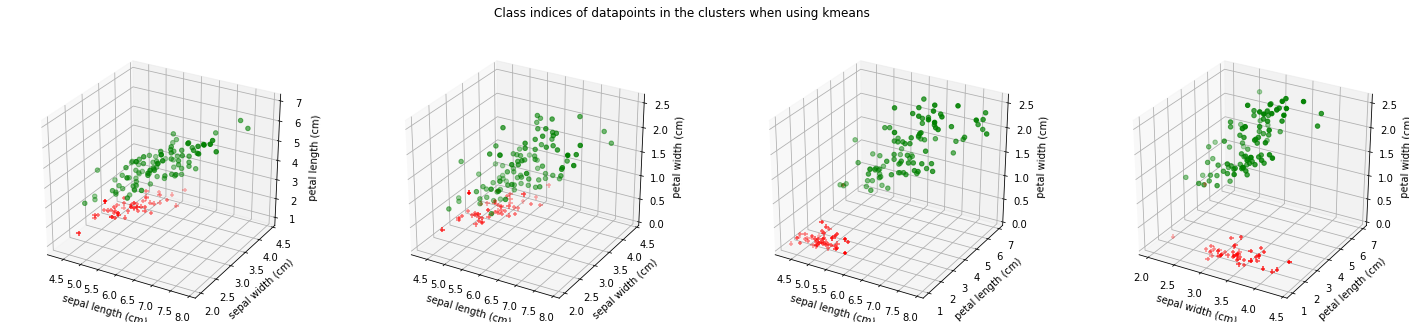

In [38]:
threedimensional_clusters_plotter(iris.feature_names, pso_clusters, pso_cluster_indices, 'kmeans')

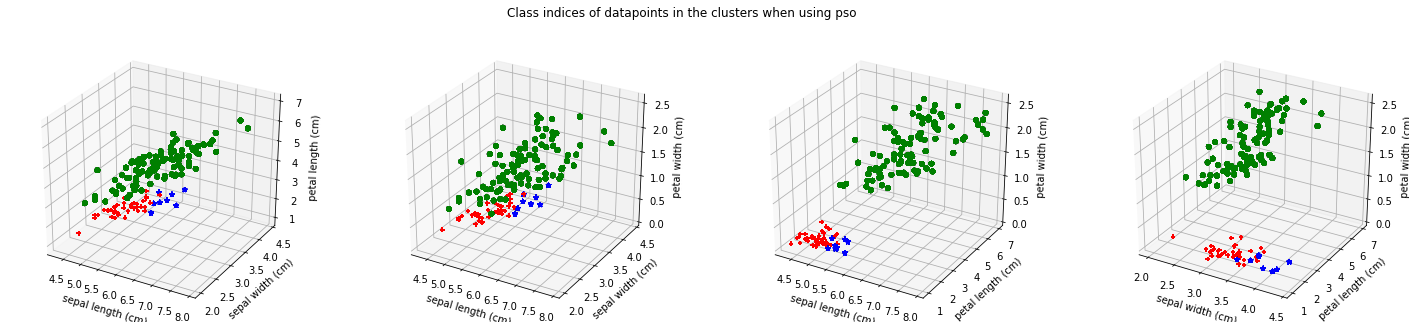

In [39]:
threedimensional_clusters_plotter(iris.feature_names, clusters, cluster_indices, 'pso')